In [304]:
from dataset import ApAvDataset, significance_test

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

import arviz as az

import jax
import jax.numpy as jnp

import numpyro
import numpyro.infer
# import render
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam
from numpyro.contrib.control_flow import scan



In [309]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [386]:
from models import simple_mechanistic_model, latent_utility_model_nostim, latent_utility_model_stim

In [47]:
import itertools
from pathlib import Path

import jax

from numpyro import handlers
import numpyro.distributions as dist


def get_model_relations(model, model_args=None, model_kwargs=None, num_tries=10):
    """
    Infer relations of RVs and plates from given model and optionally data.
    See https://github.com/pyro-ppl/numpyro/issues/949 for more details.
    This returns a dictionary with keys:
    -  "sample_sample" map each downstream sample site to a list of the upstream
       sample sites on which it depend;
    -  "sample_dist" maps each sample site to the name of the distribution at
       that site;
    -  "plate_sample" maps each plate name to a lists of the sample sites
       within that plate; and
    -  "observe" is a list of observed sample sites.
    For example for the model::
        def model(data):
            m = numpyro.sample('m', dist.Normal(0, 1))
            sd = numpyro.sample('sd', dist.LogNormal(m, 1))
            with numpyro.plate('N', len(data)):
                numpyro.sample('obs', dist.Normal(m, sd), obs=data)
    the relation is::
        {'sample_sample': {'m': [], 'sd': ['m'], 'obs': ['m', 'sd']},
         'sample_dist': {'m': 'Normal', 'sd': 'LogNormal', 'obs': 'Normal'},
         'plate_sample': {'N': ['obs']},
         'observed': ['obs']}
    :param callable model: A model to inspect.
    :param model_args: Optional tuple of model args.
    :param model_kwargs: Optional dict of model kwargs.
    :param int num_tries: Optional number times to trace model to detect
        discrete -> continuous dependency.
    :rtype: dict
    """
    model_args = model_args or ()
    model_kwargs = model_kwargs or {}

    trace = handlers.trace(handlers.seed(model, 0)).get_trace(
        *model_args, **model_kwargs
    )
    obs_sites = [
        name
        for name, site in trace.items()
        if site["type"] == "sample" and site["is_observed"]
    ]

    def _get_dist_name(fn):
        if isinstance(
            fn, (dist.Independent, dist.ExpandedDistribution, dist.MaskedDistribution)
        ):
            return _get_dist_name(fn.base_dist)
        return type(fn).__name__

    sample_dist = {
        name: _get_dist_name(site["fn"])
        for name, site in trace.items()
        if site["type"] == "sample"
    }

    sample_plates = {
        name: [frame.name for frame in site["cond_indep_stack"]]
        for name, site in trace.items()
        if site["type"] == "sample"
    }
    plate_samples = {
        k: {name for name, plates in sample_plates.items() if k in plates}
        for k in trace
        if trace[k]["type"] == "plate"
    }

    def _resolve_plate_samples(plate_samples):
        for p, pv in plate_samples.items():
            for q, qv in plate_samples.items():
                if len(pv & qv) > 0 and len(pv - qv) > 0 and len(qv - pv) > 0:
                    plate_samples_ = plate_samples.copy()
                    plate_samples_[q] = pv & qv
                    plate_samples_[q + "__CLONE"] = qv - pv
                    return _resolve_plate_samples(plate_samples_)
        return plate_samples

    plate_samples = _resolve_plate_samples(plate_samples)
    # convert set to list to keep order of variables
    plate_samples = {
        k: [name for name in trace if name in v] for k, v in plate_samples.items()
    }

    def get_log_probs(sample, seed=0):
        with handlers.trace() as tr, handlers.seed(model, seed), handlers.substitute(
            data=sample
        ):
            model(*model_args, **model_kwargs)
        return {
            name: site["fn"].log_prob(site["value"])
            for name, site in tr.items()
            if site["type"] == "sample"
        }

    samples = {
        name: site["value"]
        for name, site in trace.items()
        if site["type"] == "sample"
        and not site["is_observed"]
        and not site["fn"].is_discrete
    }
    log_prob_grads = jax.jacobian(get_log_probs)(samples)
    sample_deps = {}
    for name, grads in log_prob_grads.items():
        sample_deps[name] = {n for n in grads if n != name and (grads[n] != 0).any()}

    # find discrete -> continuous dependency
    samples = {
        name: site["value"] for name, site in trace.items() if site["type"] == "sample"
    }
    discrete_sites = [
        name
        for name, site in trace.items()
        if site["type"] == "sample"
        and not site["is_observed"]
        and site["fn"].is_discrete
    ]
    log_probs_prototype = get_log_probs(samples)
    for name in discrete_sites:
        samples_ = samples.copy()
        samples_.pop(name)
        for i in range(num_tries):
            log_probs = get_log_probs(samples_, seed=i + 1)
            for var in samples:
                if var == name:
                    continue
                if (log_probs[var] != log_probs_prototype[var]).any():
                    sample_deps[var] |= {name}
    sample_sample = {}
    for name in samples:
        sample_sample[name] = [var for var in samples if var in sample_deps[name]]
    return {
        "sample_sample": sample_sample,
        "sample_dist": sample_dist,
        "plate_sample": plate_samples,
        "observed": obs_sites,
    }


def generate_graph_specification(model_relations):
    """
    Convert model relations into data structure which can be readily
    converted into a network.
    """
    # group nodes by plate
    plate_groups = dict(model_relations["plate_sample"])
    plate_rvs = {rv for rvs in plate_groups.values() for rv in rvs}
    plate_groups[None] = [
        rv for rv in model_relations["sample_sample"] if rv not in plate_rvs
    ]  # RVs which are in no plate

    # retain node metadata
    node_data = {}
    for rv in model_relations["sample_sample"]:
        node_data[rv] = {
            "is_observed": rv in model_relations["observed"],
            "distribution": model_relations["sample_dist"][rv],
        }

    # infer plate structure
    # (when the order of plates cannot be determined from subset relations,
    # it follows the order in which plates appear in trace)
    plate_data = {}
    for plate1, plate2 in list(itertools.combinations(plate_groups, 2)):
        if plate1 is None or plate2 is None:
            continue

        if set(plate_groups[plate1]) < set(plate_groups[plate2]):
            plate_data[plate1] = {"parent": plate2}
        elif set(plate_groups[plate1]) >= set(plate_groups[plate2]):
            plate_data[plate2] = {"parent": plate1}

    for plate in plate_groups:
        if plate is None:
            continue

        if plate not in plate_data:
            plate_data[plate] = {"parent": None}

    # infer RV edges
    edge_list = []
    for target, source_list in model_relations["sample_sample"].items():
        edge_list.extend([(source, target) for source in source_list])

    return {
        "plate_groups": plate_groups,
        "plate_data": plate_data,
        "node_data": node_data,
        "edge_list": edge_list,
    }


def render_graph(graph_specification, render_distributions=False):
    """
    Create a graphviz object given a graph specification.
    :param bool render_distributions: Show distribution of each RV in plot.
    """
    try:
        import graphviz  # noqa: F401
    except ImportError as e:
        raise ImportError(
            "Looks like you want to use graphviz (https://graphviz.org/) "
            "to render your model. "
            "You need to install `graphviz` to be able to use this feature. "
            "It can be installed with `pip install graphviz`."
        ) from e

    plate_groups = graph_specification["plate_groups"]
    plate_data = graph_specification["plate_data"]
    node_data = graph_specification["node_data"]
    edge_list = graph_specification["edge_list"]

    graph = graphviz.Digraph()

    # add plates
    plate_graph_dict = {
        plate: graphviz.Digraph(name=f"cluster_{plate}")
        for plate in plate_groups
        if plate is not None
    }
    for plate, plate_graph in plate_graph_dict.items():
        plate_graph.attr(label=plate.split("__CLONE")[0], labeljust="r", labelloc="b")

    plate_graph_dict[None] = graph

    # add nodes
    for plate, rv_list in plate_groups.items():
        cur_graph = plate_graph_dict[plate]

        for rv in rv_list:
            color = "grey" if node_data[rv]["is_observed"] else "white"
            cur_graph.node(
                rv, label=rv, shape="ellipse", style="filled", fillcolor=color
            )

    # add leaf nodes first
    while len(plate_data) >= 1:
        for plate, data in plate_data.items():
            parent_plate = data["parent"]
            is_leaf = True

            for plate2, data2 in plate_data.items():
                if plate == data2["parent"]:
                    is_leaf = False
                    break

            if is_leaf:
                plate_graph_dict[parent_plate].subgraph(plate_graph_dict[plate])
                plate_data.pop(plate)
                break

    # add edges
    for source, target in edge_list:
        graph.edge(source, target)

    # render distributions if requested
    if render_distributions:
        dist_label = ""
        for rv, data in node_data.items():
            rv_dist = data["distribution"]
            dist_label += rf"{rv} ~ {rv_dist}\l"

        graph.node("distribution_description_node", label=dist_label, shape="plaintext")

    # return whole graph
    return graph


def render_model(
    model,
    model_args=None,
    model_kwargs=None,
    filename=None,
    render_distributions=False,
    num_tries=10,
):
    """
    Wrap all functions needed to automatically render a model.
    .. warning:: This utility does not support the
        :func:`~numpyro.contrib.control_flow.scan` primitive yet.
    .. warning:: Currently, this utility uses a heuristic approach,
        which will work for most cases, to detect dependencies in a NumPyro model.
    :param model: Model to render.
    :param model_args: Positional arguments to pass to the model.
    :param model_kwargs: Keyword arguments to pass to the model.
    :param str filename: File to save rendered model in.
    :param bool render_distributions: Whether to include RV distribution annotations in the plot.
    :param int num_tries: Times to trace model to detect discrete -> continuous dependency.
    """
    relations = get_model_relations(
        model, model_args=model_args, model_kwargs=model_kwargs, num_tries=num_tries
    )
    graph_spec = generate_graph_specification(relations)
    graph = render_graph(graph_spec, render_distributions=render_distributions)

    if filename is not None:
        filename = Path(filename)
        graph.render(
            filename.stem, view=False, cleanup=True, format=filename.suffix[1:]
        )  # remove leading period from suffix

    return graph

In [5]:
# path_to_data = '/Users/julianstastny/Code/masters-thesis/test_data_for_sebastian/three_consecutive_days'
path_to_data = '/Users/julianstastny/Code/masters-thesis/data/AMED-DFG/behavior'
dataset = ApAvDataset(path_to_data=path_to_data)

In [587]:
import pickle

In [592]:
with open('ApAvDataset_behavior.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [270]:
all_data = dataset.get_data(monkey_id=2, full_sessions_only=True)
all_data = significance_test(all_data)

In [468]:
NUM_SESSIONS=2

In [471]:
data = [datum for datum in all_data if (datum['metadata']['significant_diff'] and datum['metadata']['stim_increases_avoidance'])][1:NUM_SESSIONS]

In [472]:
session_lengths = [sum(datum['metadata']['datanums'].values()) for datum in data]

In [473]:
session_lengths

[601]

In [474]:
len(significant_data_negative)

22

In [475]:
len(data)

1

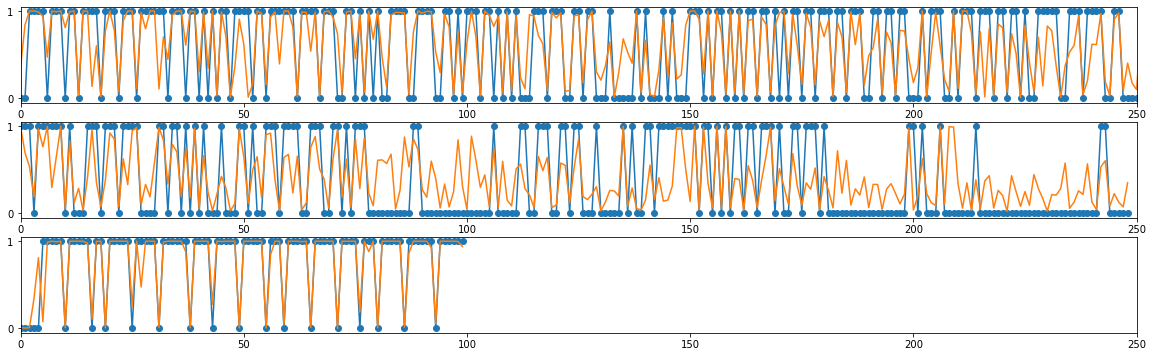

In [486]:
for j in range(min(len(data), 3)):
    clf = linear_model.LogisticRegression()
#     j = 0
    fig, axes = plt.subplots(3, 1, figsize=(20, 6))
    for i, stage in enumerate(['stim0', 'stim1', 'resid']):
        _X = data[j][stage][['reward_amount', 'aversi_amount']]
        _y = data[j][stage]['appro1_avoid0']
        clf.fit(_X, _y)
        probs = clf.predict_proba(_X)[:,1]
        axes[i].plot(_y, marker='o')
        axes[i].plot(probs)
        axes[i].set_xlim(0, 250)
        axes[i].set_yticks([0, 1])

In [298]:
# concatenated_data = pd.concat((data[0]['stim0'], data[0]['stim1'], data[0]['resid']))
# # two_state_data = pd.concat((data[0]['stim0'], data[0]['stim1'], data[0]['resid']))
# # two_state_data['stim1nostim0'] = [0] * len(data[0]['stim0']) + [1] * len(data[0]['stim1']) + [0] * len(data[0]['resid'])
# concatenated_data['num_stim1_trials'] = [0] * len(data[0]['stim0']) + list(range(1, len(data[0]['stim1'])+1)) + [len(data[0]['stim1'])] * len(data[0]['resid'])
# concatenated_data['num_resid_trials'] = [0] * len(data[0]['stim0']) + [0] * len(data[0]['stim1']) + list(range(1, len(data[0]['resid'])+1))

# scaler = preprocessing.StandardScaler().fit(concatenated_data[['reward_amount', 'aversi_amount']])
# # concatenated_data[['reward_amount', 'aversi_amount']] *= 0.01
# scaler.mean_
# concatenated_data[['reward_amount', 'aversi_amount']] = scaler.transform(concatenated_data[['reward_amount', 'aversi_amount']])

In [568]:
concatenated_data = pd.concat([pd.concat((data[i]['stim0'], data[i]['stim1'], data[i]['resid'])) for i in range(len(data))])
stage = np.concatenate([np.array([0] * len(data[i]['stim0']) + [1] * len(data[i]['stim1']) + [2] * len(data[i]['resid'])) for i in range(len(data))], 0)
stim_indicator = np.concatenate([np.array([0] * len(data[i]['stim0']) + [1] * len(data[i]['stim1']) + [0] * len(data[i]['resid'])) for i in range(len(data))], 0)
# two_state_data = pd.concat((data[0]['stim0'], data[0]['stim1'], data[0]['resid']))
# two_state_data['stim1nostim0'] = [0] * len(data[0]['stim0']) + [1] * len(data[0]['stim1']) + [0] * len(data[0]['resid'])
# concatenated_data['num_stim1_trials'] = [0] * len(data[0]['stim0']) + list(range(1, len(data[0]['stim1'])+1)) + [len(data[0]['stim1'])] * len(data[0]['resid'])
# concatenated_data['num_resid_trials'] = [0] * len(data[0]['stim0']) + [0] * len(data[0]['stim1']) + list(range(1, len(data[0]['resid'])+1))

scaler = preprocessing.StandardScaler().fit(concatenated_data[['reward_amount', 'aversi_amount']])
# concatenated_data[['reward_amount', 'aversi_amount']] *= 0.01
scaler.mean_
concatenated_data[['reward_amount', 'aversi_amount']] = scaler.transform(concatenated_data[['reward_amount', 'aversi_amount']])

# X_data = np.array(concatenated_data[['reward_amount', 'aversi_amount', 'num_stim1_trials', 'num_resid_trials']])
X = np.array(concatenated_data[['reward_amount', 'aversi_amount']])
# stim_durations = np.array(concatenated_data[['num_stim1_trials', 'num_resid_trials']])
# X_scaled = scaler.transform(X)
y = np.array(concatenated_data[['appro1_avoid0']]).flatten()
# num_stim = np.array(concatenated_data['num_stim1_trials'])
# num_resid = np.array(concatenated_data['num_resid_trials'])
# num_trials_per_stage = [len(data[0]['stim0']), len(data[0]['stim1']), len(data[0]['resid'])]

print(X.shape)
# print(X_data.shape)
print(y.shape)
# print(num_stim.shape)
# print(num_trials_per_stage)

(601, 2)
(601,)


In [505]:
print(X)

[[-1.00823573 -1.03741366]
 [-0.21056618 -0.06753917]
 [ 2.3020929   0.83049276]
 ...
 [ 1.9431416   1.47707575]
 [-0.05103227 -0.75004344]
 [-0.44986704 -1.14517749]]


In [478]:
stage.shape

(601,)

behavior(2011-06-02_16-55-52).mat
[[ 0.19311299 -0.05890971]]
(252, 2)
[[ 0.0873119  -0.03365202]]
(249, 2)
[[ 0.40248782 -0.07979019]]
(100, 2)


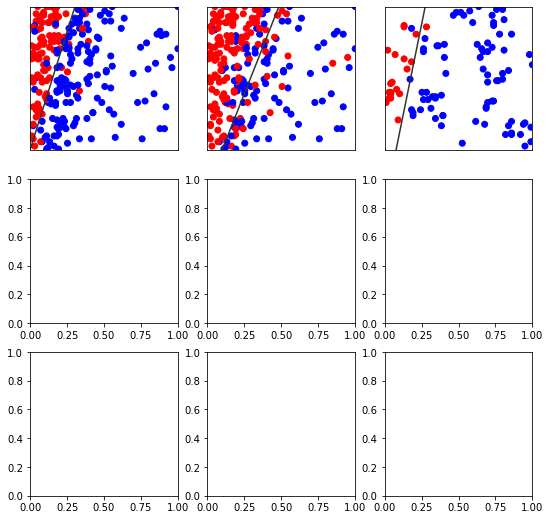

In [479]:
import matplotlib.ticker as ticker

num_blocks_stim1 = 1
num_blocks_resid = 1
num_rows = 3
num_cols = 1 + num_blocks_stim1 + num_blocks_resid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 3, num_rows * 3))

clf = linear_model.LogisticRegression()

# random.shuffle(data)

def chunks(df, n):
    """Yield successive n-sized chunks from df."""
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]

def plot_all(X, y, i, j):
#     X = scaler.transform(X)
    X = np.array(X)
    ax = axes[i, j]
    clf = linear_model.LogisticRegression()

    clf.fit(X, y)
    ap_prob = clf.decision_function([[50, 50]])[0]
    if i==0:
        print(clf.coef_)

#     xx, yy = np.mgrid[-2:2:0.01, -2:2:0.01]
    xx, yy = np.mgrid[0:100:1, 0:100:1]

    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    print(X.shape)
    ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr_r')
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * scaler.scale_[0] + scaler.mean_[0]))    
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * scaler.scale_[1] + scaler.mean_[1]))    
    ax.xaxis.set_major_formatter(ticks_x)
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xticks([])
    ax.set_yticks([])


for i, datum in enumerate(data[:3]):

    print(datum['metadata']['matlab_filename'])

    stage = 'stim0'
    X = datum[stage][['reward_amount', 'aversi_amount']]
    y = datum[stage]['appro1_avoid0']
    plot_all(X, y, i, 0)

    stage = 'stim1'
    num_chunks = len(datum[stage]) // num_blocks_stim1
    X = chunks(datum[stage][['reward_amount', 'aversi_amount']], num_chunks)
    y = chunks(datum[stage]['appro1_avoid0'], num_chunks)
    for j in range(1, num_blocks_stim1 + 1):
        plot_all(next(X), next(y), i, j)

    stage = 'resid'
    num_chunks = len(datum[stage]) // num_blocks_resid
    X = chunks(datum[stage][['reward_amount', 'aversi_amount']], num_chunks)
    y = chunks(datum[stage]['appro1_avoid0'], num_chunks)
    for j in range(num_blocks_stim1+1, num_blocks_stim1 + num_blocks_resid + 1):
        plot_all(next(X), next(y), i, j)

In [279]:
# X_data = np.array(concatenated_data[['reward_amount', 'aversi_amount', 'num_stim1_trials', 'num_resid_trials']])
# X = np.array(concatenated_data[['reward_amount', 'aversi_amount']])
# stim_durations = np.array(concatenated_data[['num_stim1_trials', 'num_resid_trials']])
# # X_scaled = scaler.transform(X)
# y = np.array(concatenated_data[['appro1_avoid0']]).flatten()
# num_stim = np.array(concatenated_data['num_stim1_trials'])
# num_resid = np.array(concatenated_data['num_resid_trials'])
# num_trials_per_stage = [len(data[0]['stim0']), len(data[0]['stim1']), len(data[0]['resid'])]

# print(X.shape)
# print(X_data.shape)
# print(y.shape)
# print(num_stim.shape)
# print(num_trials_per_stage)

In [280]:
# def additive_effect_model(X, stim_durations, y=None):
    
#     weight_plate = numpyro.plate('num_weights', 3, dim=-1)
#     stim_plate = numpyro.plate('stim+resid', 2, dim=-2)
#     trials_plate = numpyro.plate('num_trials', len(y), dim=-1)
    
#     with weight_plate:
#         weights = numpyro.sample('weights', dist.Normal(jnp.zeros(3), 10))
#         with stim_plate:
#             stim_effect = numpyro.sample('stim_effect', dist.Normal(jnp.zeros((2, 3)), jnp.ones((2, 3))*10))
#             stimulated_weights = numpyro.deterministic(
#                 'stimulated_weights', weights + stim_effect[0] * jnp.log(jnp.tile(stim_durations[:,0], (3, 1)).T + 1) + stim_effect[1] * jnp.log(jnp.tile(stim_durations[:,1], (3, 1)).T + 1))
#     with trials_plate:
#         probs = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
#         obs = numpyro.sample('y', dist.BernoulliLogits(probs), obs=y)

In [253]:
def additive_effect_model(X, stim_durations, y=None):
    weights = numpyro.sample('weights', dist.Normal(jnp.zeros(3), 10))
    stim_effect = numpyro.sample('stim_effect', dist.Normal(jnp.zeros((2, 3)), jnp.ones((2, 3))*10))
    stimulated_weights = numpyro.deterministic(
        'stimulated_weights', weights + stim_effect[0] * jnp.log(jnp.tile(stim_durations[:,0], (3, 1)).T + 1) + stim_effect[1] * jnp.log(jnp.tile(stim_durations[:,1], (3, 1)).T + 1))
    logits = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
    with numpyro.plate('num_trials', len(y)):
        obs = numpyro.sample('y', dist.BernoulliLogits(logits=logits), obs=y)

In [254]:
def overfitting_random_walk_model(X, y=None):
    init_w = numpyro.sample('initial_weight', dist.Normal(jnp.zeros((3, 1)), 10))
    w = numpyro.sample('weight_walk', dist.GaussianRandomWalk(scale=np.ones(3), num_steps=len(y)))
    stimulated_weights = numpyro.deterministic('stimulated_weights', (w + init_w).T)
    logits = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
    with numpyro.plate('num_trials', len(y)):
        obs = numpyro.sample('y', dist.BernoulliLogits(logits=logits), obs=y)

In [488]:
def regularized_random_walk_model(X, y=None):
    X = numpyro.deterministic('X', X)
    init_w = numpyro.sample('initial_weight', dist.Normal(jnp.zeros((3, 1)), 10))
#     w = numpyro.sample('weight_walk', dist.GaussianRandomWalk(scale=np.ones(3)* 0.1, num_steps=len(y)))
    with numpyro.handlers.reparam(config={"weight_walk": TransformReparam()}):
        w = numpyro.sample(
            "weight_walk",
            dist.TransformedDistribution(
                dist.GaussianRandomWalk(scale=np.ones(3), num_steps=len(y)),
                dist.transforms.AffineTransform(0, 0.1),
            ),
        )
    stimulated_weights = numpyro.deterministic('stimulated_weights', (w + init_w).T)
    logits = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
    with numpyro.plate('num_trials', len(y)):
        obs = numpyro.sample('y', dist.BernoulliLogits(logits=logits), obs=y)

In [256]:
# regularized_random_walk_model = reparam(regularized_random_walk_model, config={'initial_weight': LocScaleReparam(0)})

In [257]:
# def psytrack_model(X, sess_lengths, y=None):
#     weights = []
#     for sess_i, n_trials in enumerate(sess_lengths):
# #         if not sess_i:
# #             init_session_w = numpyro.sample(f'init_session_w_{sess_i}', dist.Normal(jnp.zeros((3, 1)), 10))
# #         else:
# #             init_session_w = numpyro.sample(f'init_session_w_{sess_i}', dist.Normal(jnp.expand_dims(weights[-1][:,-1], 1), 10))
#         init_session_w = numpyro.sample(f'init_session_w_{sess_i}', dist.Normal(jnp.zeros((3, 1)), 10))

# #         with numpyro.handlers.reparam(config={f"weight_walk_{sess_i}": TransformReparam()}):
# #             w = numpyro.sample(
# #                 f"weight_walk_{sess_i}",
# #                 dist.TransformedDistribution(
# #                     dist.GaussianRandomWalk(scale=np.ones(3), num_steps=n_trials - 1),
# #                     dist.transforms.AffineTransform(0, 0.1),
# #                 ),
# #             )
#         w = numpyro.sample(f"weight_walk_{sess_i}", dist.GaussianRandomWalk(scale=np.ones(3)*0.1, num_steps=n_trials - 1))
# #         print(init_session_w.shape)
# #         print(w.shape)
#         weights += [init_session_w]
#         weights += [w + init_session_w]
#     stimulated_weights = numpyro.deterministic('stimulated_weights', jnp.concatenate(weights, axis=1).T)
# #     print(stimulated_weights.shape)
        
# #     stimulated_weights = numpyro.deterministic('stimulated_weights', (w + init_w).T)
#     logits = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
#     with numpyro.plate('num_trials', len(y)):
#         obs = numpyro.sample('y', dist.BernoulliLogits(logits=logits), obs=y)

In [258]:
def psytrack_model(X, sess_lengths, y=None):
    with numpyro.plate('num_sessions', len(sess_lengths), dim=-2):
        init_session = numpyro.sample(f'init_session', dist.Normal(jnp.zeros(3), 10))
        print(init_session.shape)
        weights = []
        for sess_i, n_trials in enumerate(sess_lengths):
    #         with numpyro.handlers.reparam(config={f"weight_walk_{sess_i}": TransformReparam()}):
    #             w = numpyro.sample(
    #                 f"weight_walk_{sess_i}",
    #                 dist.TransformedDistribution(
    #                     dist.GaussianRandomWalk(scale=np.ones(3), num_steps=n_trials - 1),
    #                     dist.transforms.AffineTransform(0, 0.1),
    #                 ),
    #             )
            w = numpyro.sample(f"weight_walk_{sess_i}", dist.GaussianRandomWalk(scale=np.ones(3)*0.1, num_steps=n_trials - 1))
            init_weight_sess = jnp.expand_dims(init_session[sess_i], 1)
            weights += [init_weight_sess]
            print(w.shape)
            weights += [w + init_weight_sess]
        stimulated_weights = numpyro.deterministic('stimulated_weights', jnp.concatenate(weights, axis=1).T)
        
#     stimulated_weights = numpyro.deterministic('stimulated_weights', (w + init_w).T)
    logits = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
    with numpyro.plate('num_trials', len(y)):
        obs = numpyro.sample('y', dist.BernoulliLogits(logits=logits), obs=y)

In [259]:
def psytrack_model(X, sess_lengths, y=None):
    with numpyro.plate('num_sessions', len(sess_lengths)):
        init_session = numpyro.sample(f'init_session', dist.Normal(jnp.zeros((3, 1)), 10))
        print(init_session)
    weights = []
    for sess_i, n_trials in enumerate(sess_lengths):
#         with numpyro.handlers.reparam(config={f"weight_walk_{sess_i}": TransformReparam()}):
#             w = numpyro.sample(
#                 f"weight_walk_{sess_i}",
#                 dist.TransformedDistribution(
#                     dist.GaussianRandomWalk(scale=np.ones(3), num_steps=n_trials - 1),
#                     dist.transforms.AffineTransform(0, 0.1),
#                 ),
#             )
        w = numpyro.sample(f"weight_walk_{sess_i}", dist.GaussianRandomWalk(scale=np.ones(3)*0.1, num_steps=n_trials - 1))
        init_weight_sess = jnp.expand_dims(init_session[:,sess_i], 1)
        weights += [init_weight_sess]
        weights += [w + init_weight_sess]
    stimulated_weights = numpyro.deterministic('stimulated_weights', jnp.concatenate(weights, axis=1).T)
    print(stimulated_weights.shape)
        `
#     stimulated_weights = numpyro.deterministic('stimulated_weights', (w + init_w).T)
    logits = X[:,0] * stimulated_weights[:,0] + X[:,1] * stimulated_weights[:,1] + stimulated_weights[:,2]
    with numpyro.plate('num_trials', len(y)):
        obs = numpyro.sample('y', dist.BernoulliLogits(logits=logits), obs=y)

In [260]:
numpyro.__version__

'0.6.0'

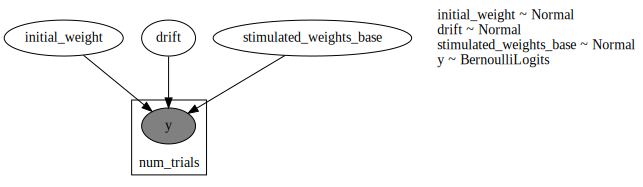

In [569]:
render_model(simple_mechanistic_model, model_args=(X, stage, y), render_distributions=True)

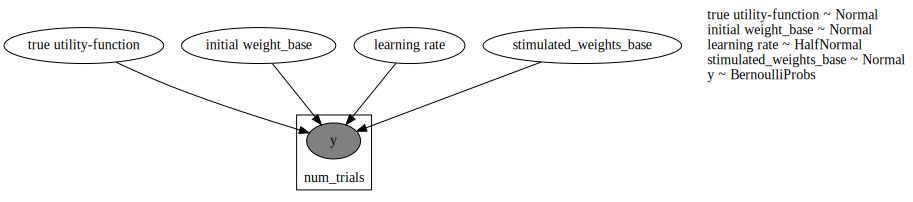

In [376]:
render_model(latent_utility_model_nostim, model_args=(X, y), render_distributions=True)

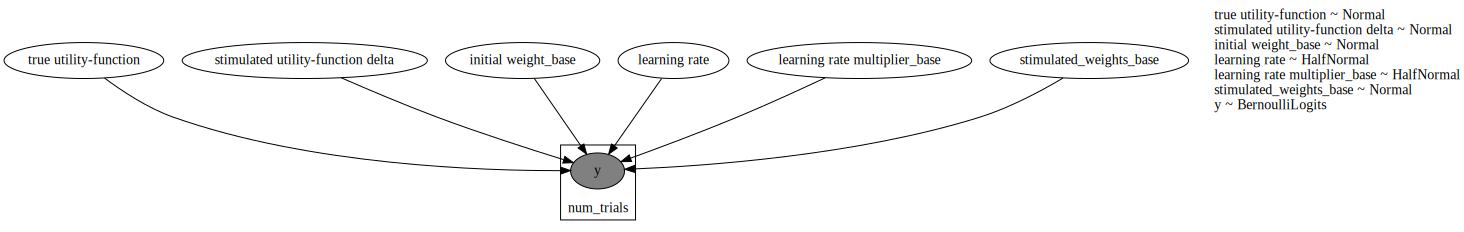

In [559]:
render_model(latent_utility_model_stim, model_args=(X, stim_indicator, y), render_distributions=True)

[[ -3.8812613   -0.44871715 -20.427265  ]
 [  0.7932303   -0.46170515   7.9599743 ]
 [-14.411982   -16.929983    -3.7369213 ]]
(1800, 3)
Traced<ConcreteArray([[ -3.8812613   -0.44871715 -20.427265  ]
 [  0.7932303   -0.46170515   7.9599743 ]
 [-14.411982   -16.929983    -3.7369213 ]])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([[ -3.8812613   -0.44871715 -20.427265  ]
                 [  0.7932303   -0.46170515   7.9599743 ]
                 [-14.411982   -16.929983    -3.7369213 ]]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float32[3,3]):JaxprTrace(level=1/0)>
(1800, 3)
[[ -3.8812613   -0.44871715 -20.427265  ]
 [  0.7932303   -0.46170515   7.9599743 ]
 [-14.411982   -16.929983    -3.7369213 ]]
(1800, 3)


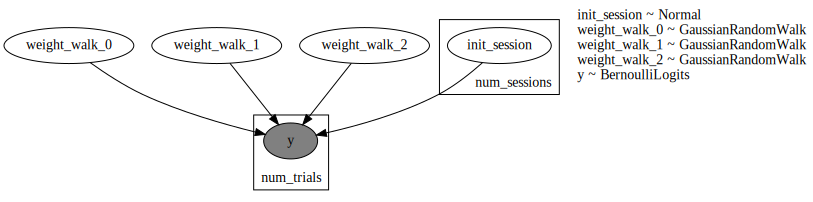

In [261]:
render_model(psytrack_model, model_args=(X, session_lengths, y), render_distributions=True)

In [262]:
render_model(additive_effect_model, model_args=(X, stim_durations, y), render_distributions=True)

NameError: name 'stim_durations' is not defined

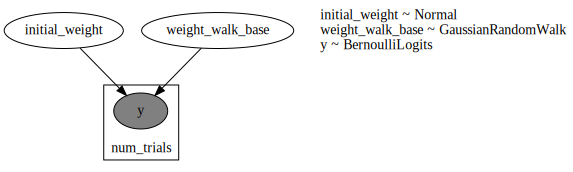

In [489]:
render_model(regularized_random_walk_model, model_args=(X, y), render_distributions=True)

In [585]:
def fit(model, num_chains, num_warmup=1000, num_samples=1000, rng_seed=0, **kwargs):
    assert set(kwargs.keys()) <= set(model.__code__.co_varnames), model.__code__.co_varnames
    assert ('X' in kwargs.keys()) and ('y' in kwargs.keys())
    nuts_kernel = NUTS(model, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_chains=num_chains, num_warmup=num_warmup, num_samples=num_samples)
    rng_key = jax.random.PRNGKey(rng_seed)
    mcmc.run(rng_key, **kwargs)
    return mcmc, az.from_numpyro(mcmc)

In [586]:
mcmc_result = fit(simple_mechanistic_model, 1, X=X, stage=stage, y=y)

AssertionError: ('X', 'stage', 'y', 'init_weight', 'transition', '_', 'weights', 'logits', 'obs')

In [561]:
mcmc.print_summary()


                                          mean       std    median      5.0%     95.0%     n_eff     r_hat
              initial weight_base[0]      0.70      0.80      0.79     -0.80      1.65      7.84      1.18
              initial weight_base[1]      0.03      1.22     -0.20     -1.30      1.69      2.89      1.81
              initial weight_base[2]     -0.58      0.72     -0.50     -1.88      0.50     16.75      1.08
                       learning rate      0.26      0.13      0.28      0.07      0.41      3.84      1.52
    learning rate multiplier_base[0]      1.18      0.73      1.19      0.08      1.97      4.40      1.81
    learning rate multiplier_base[1]      1.16      0.90      0.86      0.21      2.44      2.72      1.96
    learning rate multiplier_base[2]      0.55      0.48      0.58      0.00      1.19     30.36      1.11
stimulated utility-function delta[0]     -0.73      1.05     -1.15     -1.67      0.99      2.21      3.18
stimulated utility-function delta[1]

In [562]:
idata = az.from_numpyro(mcmc)

In [319]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [331]:
np.concatenate(idata['posterior']['stimulated_weights'], axis=0).shape

(4000, 599, 3)

/Users/julianstastny/miniconda3/envs/mastersthesis/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['autocorr', 'weight_walk', 'weight_walk_base'] have not been found and will be ignored
  warnings.warn(


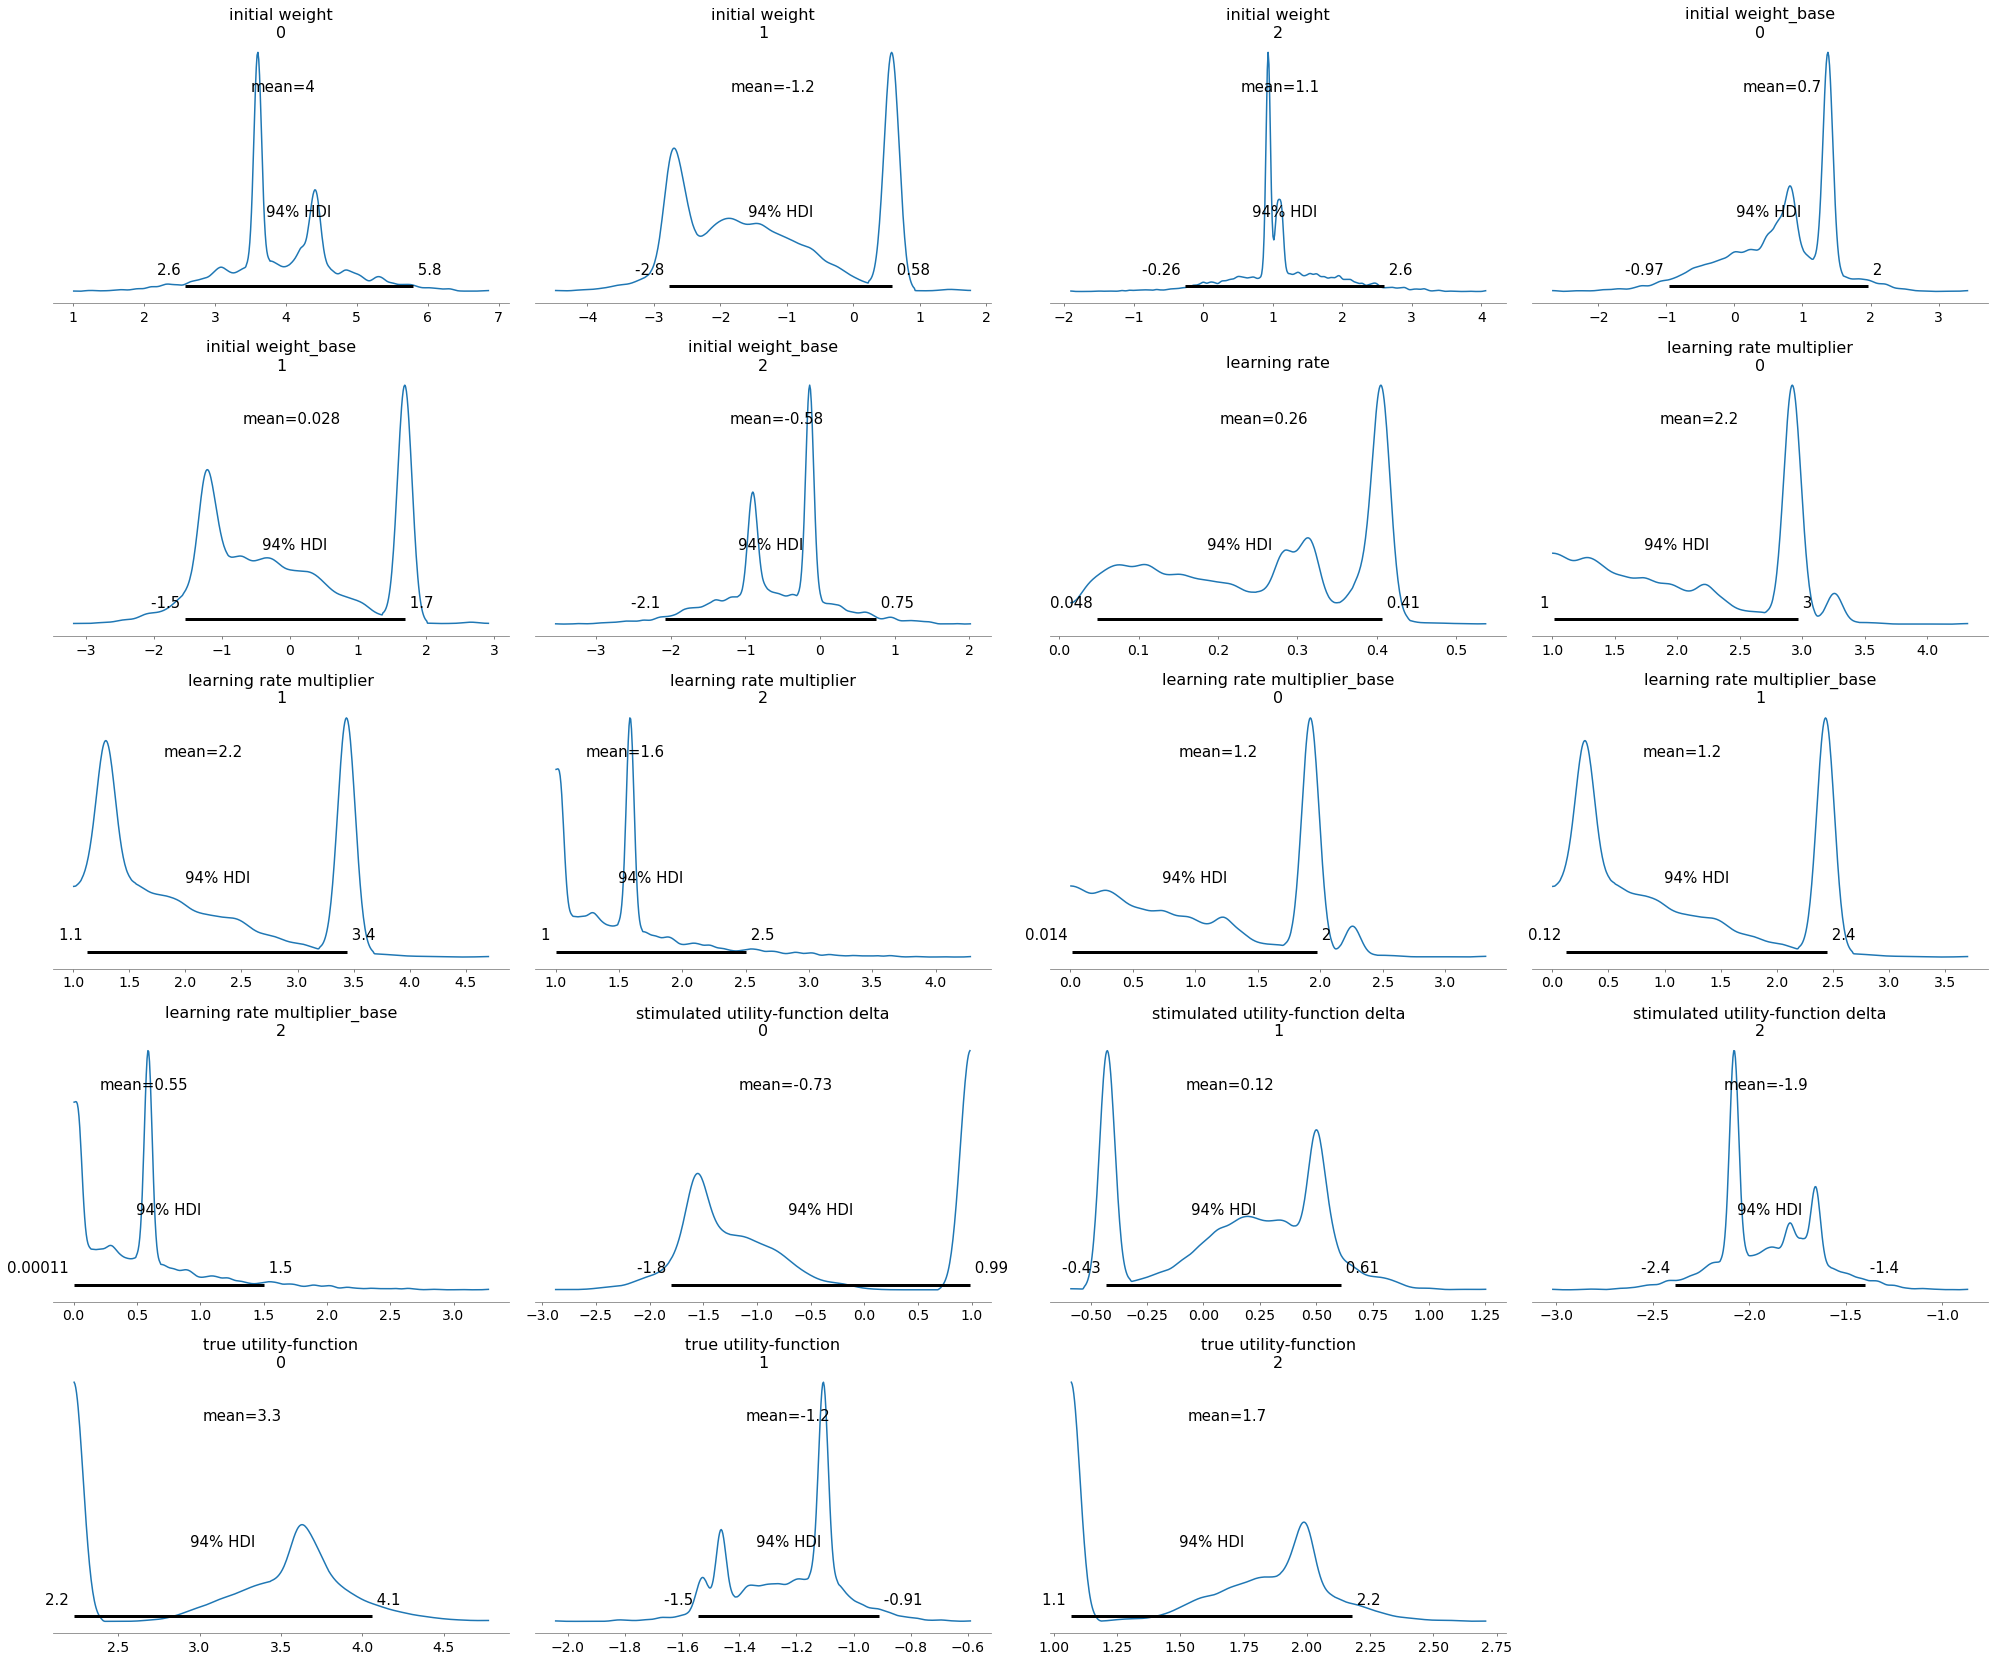

In [563]:
az.plot_posterior(idata, var_names=['~stimulated_weights','~stimulated_weights_base', '~autocorr', '~weight_walk', '~weight_walk_base', '~logits']);

/Users/julianstastny/miniconda3/envs/mastersthesis/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['autocorr', 'weight_walk', 'weight_walk_base'] have not been found and will be ignored
  warnings.warn(


array([[<AxesSubplot:title={'center':'initial weight'}>,
        <AxesSubplot:title={'center':'initial weight'}>],
       [<AxesSubplot:title={'center':'initial weight_base'}>,
        <AxesSubplot:title={'center':'initial weight_base'}>],
       [<AxesSubplot:title={'center':'learning rate'}>,
        <AxesSubplot:title={'center':'learning rate'}>],
       [<AxesSubplot:title={'center':'learning rate multiplier'}>,
        <AxesSubplot:title={'center':'learning rate multiplier'}>],
       [<AxesSubplot:title={'center':'learning rate multiplier_base'}>,
        <AxesSubplot:title={'center':'learning rate multiplier_base'}>],
       [<AxesSubplot:title={'center':'stimulated utility-function delta'}>,
        <AxesSubplot:title={'center':'stimulated utility-function delta'}>],
       [<AxesSubplot:title={'center':'true utility-function'}>,
        <AxesSubplot:title={'center':'true utility-function'}>]],
      dtype=object)

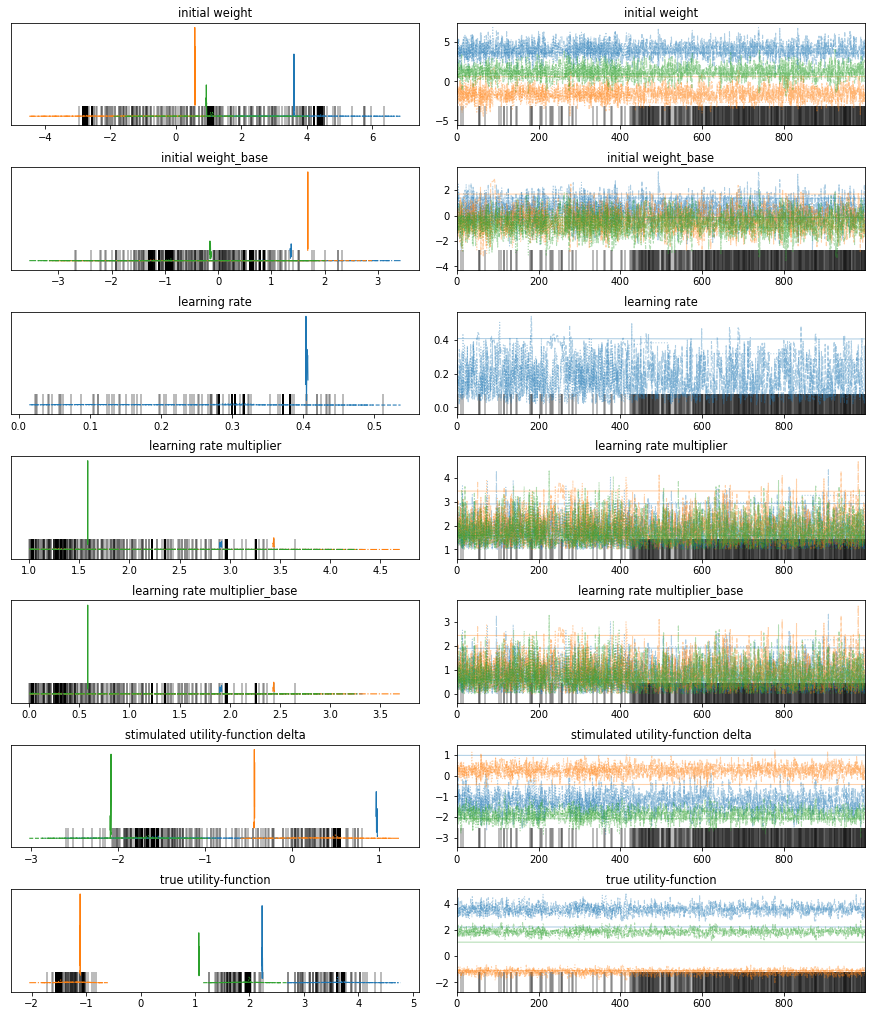

In [564]:
az.plot_trace(idata, var_names=['~stimulated_weights','~stimulated_weights_base', '~autocorr', '~weight_walk', '~weight_walk_base', '~logits'])

In [334]:
display(az.summary(idata, round_to=3, var_names=['~stimulated_weights', '~autocorr']))

/Users/julianstastny/miniconda3/envs/mastersthesis/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['autocorr'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"drift[0,0]",-0.002,0.002,-0.006,0.003,0.000,0.000,6528.043,2771.477,1.000
"drift[0,1]",-0.002,0.003,-0.007,0.004,0.000,0.000,6697.548,3344.818,1.000
"drift[0,2]",-0.005,0.002,-0.010,-0.001,0.000,0.000,7505.613,3116.040,1.001
"drift[1,0]",-0.003,0.002,-0.007,0.001,0.000,0.000,5432.694,3540.800,1.001
"drift[1,1]",0.003,0.003,-0.002,0.008,0.000,0.000,6688.326,3491.637,1.000
...,...,...,...,...,...,...,...,...,...
"stimulated_weights_base[597,1]",0.002,0.988,-1.834,1.843,0.010,0.019,9712.799,2959.081,1.002
"stimulated_weights_base[597,2]",-0.005,1.029,-1.966,1.914,0.011,0.020,9478.871,2758.007,1.004
"stimulated_weights_base[598,0]",0.011,0.967,-1.847,1.794,0.009,0.019,11125.526,2680.820,1.002
"stimulated_weights_base[598,1]",0.002,1.013,-1.896,1.825,0.010,0.021,9922.559,2719.545,1.002


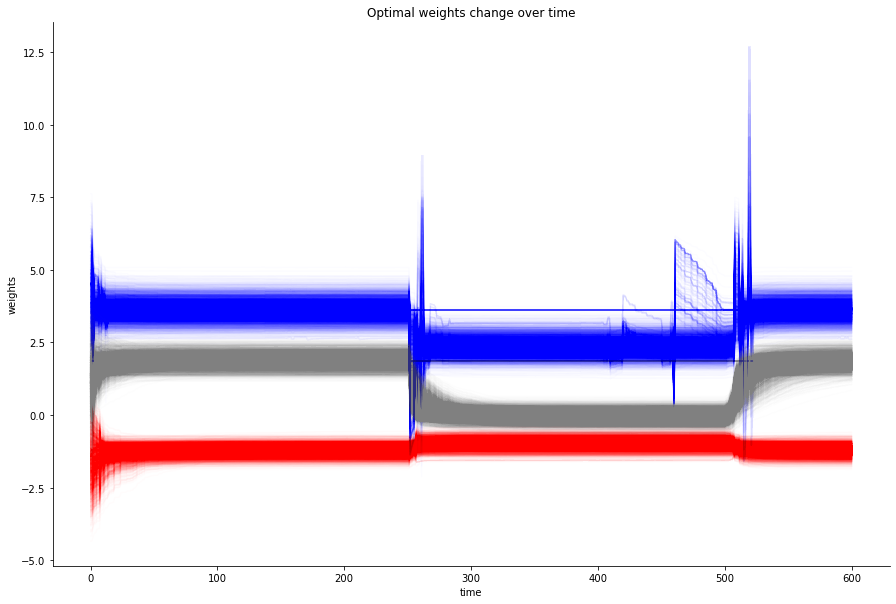

In [550]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 0].T, alpha=.01, color='b'); # Blue = reward weights
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 1].T, alpha=.01, color='r'); # Red = aversion weights
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 2].T, alpha=.01, color='grey'); # Grey = intercept

try:
    plt.hlines(np.mean(np.concatenate(idata['posterior']['true utility-function'], axis=0)[:, 0].T), 0, 600, alpha=1, color='b'); # Red = reward weights
    plt.hlines(np.mean(np.concatenate(idata['posterior']['true utility-function'], axis=0)[:, 1].T), 0, 600, alpha=1, color='r'); # Red = reward weights
    plt.hlines(np.mean(np.concatenate(idata['posterior']['true utility-function'], axis=0)[:, 2].T), 0, 600, alpha=1, color='grey'); # Red = reward weights
#     plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 1].T, alpha=.05, color='r'); # Blue = aversion weights
#     plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 2].T, alpha=.05, color='grey'); # Grey = intercept
except:
    print('No')

plt.xlabel('time'); plt.ylabel('weights'); plt.title('Optimal weights change over time'); sns.despine();
# plt.legend()

In [551]:
weights = np.array(np.mean(idata['posterior']['stimulated_weights'][0], 0))

In [552]:
clf = linear_model.LogisticRegression()
clf.fit(X, y)

try:
    autocorrelation = np.mean(idata['posterior']['autocorr'][0], 0)
    no_ac = False
except:
    no_ac = True
    print('No Autocorrelation')
print(weights.shape)

def plot_quantile(quantile, step):
    if no_ac:
        clf.intercept_ = weights[step][2]
    else:
        clf.intercept_ = weights[step][2] + autocorrelation[step]

    clf.coef_ = np.expand_dims(weights[step][:2], 0)
    # xx, yy = np.mgrid[0:1:0.01, 0:1:0.01]
    xx, yy = np.mgrid[-3:3:0.01, -3:3:0.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    # print(grid.shape)
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    # samples = predictive(torch.tensor(grid, dtype=torch.float32), z_nstim[step].tile((len(grid),1)), z_nresid[step].tile((len(grid),1)))
    # pred_summary = summary(samples)
    # probs = (pred_summary['_RETURN']['mean']).reshape(xx.shape)
    if quantile==0.5:
        plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    else:
        plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linestyles='dashed')

def f(step):
    fig = plt.figure(figsize=(15, 10))
    for q in [0.5]:
        plot_quantile(q, step)
        plt.scatter(X[:,0][np.maximum(0, step-10):step+1], X[:,1][np.maximum(0, step-10):step+1], c=y[np.maximum(0, step-10):step+1], cmap='bwr_r')



interactive_plot = interactive(f, step=widgets.IntSlider(min=0, max=len(concatenated_data)-1, step=1, layout=Layout(width='500px')))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

No Autocorrelation
(601, 3)


interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='500px'), max=600), Output(la…

In [84]:
trace['stimulated_weights'].shape

(2000, 599, 3)

In [510]:
clf = linear_model.LogisticRegression()
clf.fit(X, y)

try:
    autocorrelation = np.mean(trace['autocorr'], 0)
    no_ac = False
except:
    no_ac = True
    print('No Autocorrelation')
all_weights = np.array(idata['posterior']['stimulated_weights'][0])[-20:]

def plot_quantile(quantile, step):
    probabilities = []
    for weights in all_weights:
        if no_ac:
            clf.intercept_ = weights[step][2]
        else:
            clf.intercept_ = weights[step][2] + autocorrelation[step]
        clf.coef_ = np.expand_dims(weights[step][:2], 0)
        # xx, yy = np.mgrid[0:1:0.01, 0:1:0.01]
        xx, yy = np.mgrid[-3:3:0.01, -3:3:0.01]
        grid = np.c_[xx.ravel(), yy.ravel()]
        # print(grid.shape)
        probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
        probabilities += [probs]
        # samples = predictive(torch.tensor(grid, dtype=torch.float32), z_nstim[step].tile((len(grid),1)), z_nresid[step].tile((len(grid),1)))
        # pred_summary = summary(samples)
        # probs = (pred_summary['_RETURN']['mean']).reshape(xx.shape)
        if quantile==0.5:
#             plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, alpha=0.1)
            plt.contourf(xx, yy, np.mean(probabilities, 0), cmap='vlag_r', alpha=0.1)
        else:
            plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linestyles='dashed')

def f(step):
    fig = plt.figure(figsize=(15, 10))
    for q in [0.5]:
        plot_quantile(q, step)
        plt.scatter(X[:,0][np.maximum(0, step-10):step+1], X[:,1][np.maximum(0, step-10):step+1], c=y[np.maximum(0, step-10):step+1], cmap='bwr_r', s=100)



interactive_plot = interactive(f, step=widgets.IntSlider(min=0, max=len(concatenated_data)-1, step=1, layout=Layout(width='500px')))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

No Autocorrelation


interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='500px'), max=600), Output(la…

In [94]:
from tqdm import tqdm

In [ ]:
from matplotlib.animation import PillowWriter

fig = plt.figure(figsize=(15, 10))
path = '/Users/julianstastny/Code/masters-thesis/animations'


clf = linear_model.LogisticRegression()
clf.fit(X, y)

try:
    autocorrelation = np.mean(trace['autocorr'], 0)
    no_ac = False
except:
    no_ac = True
    print('No Autocorrelation')
all_weights = np.array(idata['posterior']['stimulated_weights'][0])[-20:]

def plot_quantile(quantile, step):
    probabilities = []
    for weights in all_weights:
        if no_ac:
            clf.intercept_ = weights[step][2]
        else:
            clf.intercept_ = weights[step][2] + autocorrelation[step]
        clf.coef_ = np.expand_dims(weights[step][:2], 0)
        # xx, yy = np.mgrid[0:1:0.01, 0:1:0.01]
        xx, yy = np.mgrid[-2:2:0.01, -2:2:0.01]
        grid = np.c_[xx.ravel(), yy.ravel()]
        # print(grid.shape)
        probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
        probabilities += [probs]
        # samples = predictive(torch.tensor(grid, dtype=torch.float32), z_nstim[step].tile((len(grid),1)), z_nresid[step].tile((len(grid),1)))
        # pred_summary = summary(samples)
        # probs = (pred_summary['_RETURN']['mean']).reshape(xx.shape)
        if quantile==0.5:
#             plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, alpha=0.1)
            plt.contourf(xx, yy, np.mean(probabilities, 0), cmap='vlag_r', alpha=0.1)
        else:
            plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linestyles='dashed')

def f(step):
    for q in [0.5]:
        plot_quantile(q, step)
        plt.scatter(X[:,0][np.maximum(0, step-10):step+1], X[:,1][np.maximum(0, step-10):step+1], c=y[np.maximum(0, step-10):step+1], cmap='bwr_r', s=100)

moviewriter = PillowWriter(fps=2)
with moviewriter.saving(fig, 'test.gif', dpi=100):
    for step in tqdm(range(len(concatenated_data))):
        f(step)
        moviewriter.grab_frame()

In [379]:
mcmc.print_summary()


                                    mean       std    median      5.0%     95.0%     n_eff     r_hat
        initial weight_base[0]      1.98      0.58      1.98      1.06      2.95   5405.06      1.00
        initial weight_base[1]     -1.85      0.63     -1.84     -2.90     -0.81   5807.98      1.00
        initial weight_base[2]      1.64      0.57      1.65      0.67      2.53   5735.22      1.00
                 learning rate      0.01      0.00      0.01      0.01      0.02   5867.85      1.00
  stimulated_weights_base[0,0]      0.02      1.02      0.02     -1.65      1.70   6156.19      1.00
  stimulated_weights_base[0,1]     -0.00      0.99     -0.00     -1.64      1.62   6518.27      1.00
  stimulated_weights_base[0,2]      0.03      1.00      0.04     -1.53      1.73   6578.16      1.00
  stimulated_weights_base[1,0]      0.00      1.03      0.01     -1.76      1.60   7369.59      1.00
  stimulated_weights_base[1,1]     -0.03      1.03     -0.02     -1.74      1.69   7396.58

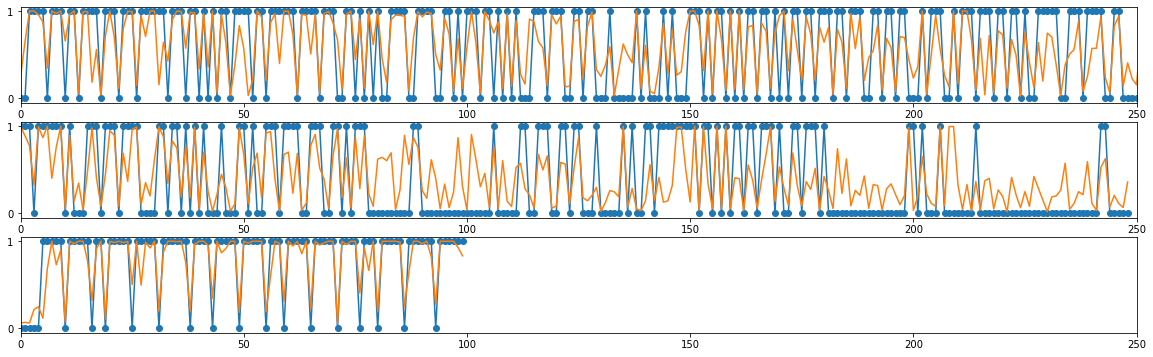

In [553]:
# clf = linear_model.LogisticRegression()
steps = iter(range(len(y)))
j = 0
fig, axes = plt.subplots(3, 1, figsize=(20, 6))
for i, stage in enumerate(['stim0', 'stim1', 'resid']):
    _X = scaler.transform(np.array(data[j][stage][['reward_amount', 'aversi_amount']]))
    _y = np.array(data[j][stage]['appro1_avoid0'])
    probs = np.empty_like(_y, dtype=np.float32)
    for k, x in enumerate(_X):
        step = next(steps)
        if no_ac:
            clf.intercept_ = weights[step][2]
        else:
            clf.intercept_ = weights[step][2] + autocorrelation[step]
        clf.coef_ = np.expand_dims(weights[step][:2], 0)
        probs[k] = clf.predict_proba([x])[0][1] 
#         probs[k] = 
    axes[i].plot(_y, marker='o')
    axes[i].plot(probs)
    axes[i].set_xlim(0, 250)
    axes[i].set_yticks([0, 1])

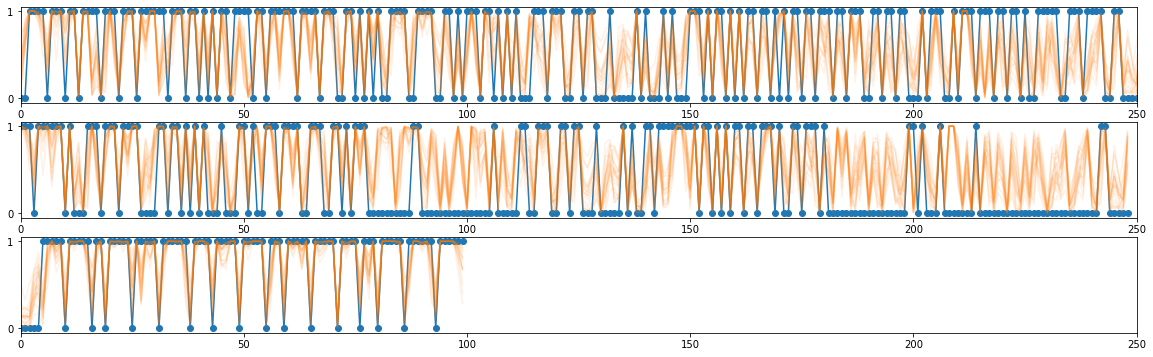

In [554]:
# clf = linear_model.LogisticRegression()
steps = iter(range(len(y)))
j = 0
fig, axes = plt.subplots(3, 1, figsize=(20, 6))
for w_i, weights in enumerate(all_weights):
    for i, stage in enumerate(['stim0', 'stim1', 'resid']):
        _X = scaler.transform(np.array(data[j][stage][['reward_amount', 'aversi_amount']]))
        _y = np.array(data[j][stage]['appro1_avoid0'])
        probs = np.empty_like(_y, dtype=np.float32)
        for k, x in enumerate(_X):
            if no_ac:
                clf.intercept_ = weights[step][2]
            else:
                clf.intercept_ = weights[step][2] + autocorrelation[step]
            clf.coef_ = np.expand_dims(weights[step][:2], 0)
            probs[k] = clf.predict_proba([x])[0][1]
        if w_i==0:
            axes[i].plot(_y, marker='o', color='#1f77b4')
        axes[i].plot(probs, alpha=0.1, color='#ff7f0e')
        axes[i].set_xlim(0, 250)
        axes[i].set_yticks([0, 1])

In [557]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [565]:
def plot_psychometric_function(logits):
    fig = plt.figure(figsize=(10, 5))
    probs = jax.nn.sigmoid(logits)
    lims = np.max(np.abs(logits))
    xrange = np.linspace(-lims, lims, 1000)
    sigma = jax.nn.sigmoid(xrange)
    plt.plot(xrange, sigma, color='black')
    plt.scatter(logits, probs, c=logits>0, cmap='bwr_r')

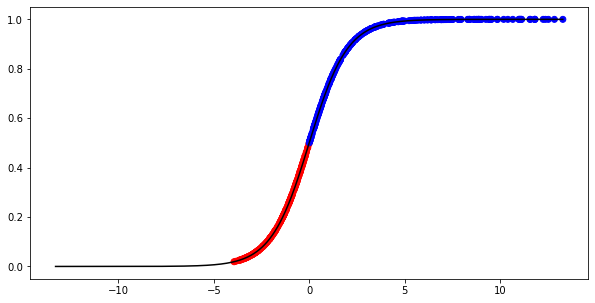

In [566]:
plot_psychometric_function(np.mean(idata.posterior.logits, axis=1)[-1])